<a href="https://colab.research.google.com/github/ZizZu94/resnet-grad-cam/blob/main/resnet_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet Grad Cam
In this notebook we will try to generate the Grad-Cam images of a pretrianed ResNet-18 model.

grad-Cam provides us with a way to look into what particular parts of the image influenced the whole model’s decision for a specifically assigned label. It is particularly useful in analyzing wrongly classified samples. The Grad-CAM algorithm is very intuitive and reasonably simple to implement.



---

The intuition behind the algorithm is based upon the fact that the model must have seen some pixels (or regions of the image) and decided on what object is present in the image. Influence in the mathematical terms can be described with a gradient. On the high-level, that is what the algorithm does. It starts with finding the gradient of the most dominant logit with respect to the latest activation map in the model. We can interpret this as some encoded features that ended up activated in the final activation map persuaded the model as a whole to choose that particular logit (subsequently the corresponding class). The gradients are then pooled channel-wise, and the activation channels are weighted with the corresponding gradients, yielding the collection of weighted activation channels. By inspecting these channels, we can tell which ones played the most significant role in the decision of the class.

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import glob

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import numpy as np

## Download data
Here we download the data and unzip it.

In [2]:
!pip install gdown
import gdown
#Use Gdown to download the validation dataset
url = "https://drive.google.com/uc?id=1caDIHeJ0jQJNOWNyXl2ODGGLoP1SZJrj"
output = "validation.zip"
gdown.download(url, output, quiet=False)

#Use Gdown to download the training dataset
url = "https://drive.google.com/uc?id=1Y0gpp-rHG91o3xtGBfda4uavXUOis6C5"
output = "train.zip"
gdown.download(url, output, quiet=False)

#Unzip the validation zip file.
!unzip -qq -o validation.zip

#Unzip the training zip file.
!unzip -qq -o train.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1caDIHeJ0jQJNOWNyXl2ODGGLoP1SZJrj
To: /content/validation.zip
100%|██████████| 361M/361M [00:01<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y0gpp-rHG91o3xtGBfda4uavXUOis6C5
To: /content/train.zip
100%|██████████| 1.25G/1.25G [00:06<00:00, 192MB/s]


## Set device
Loading a GPU if avaliable and otherwise a CPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset Classes
Create a list of our detection classes

In [4]:
#Create a list of our detection classes
classes = ["Car", "Bicycle", "Person", "Airplane"]

## Custom Dataset

Since we’re using a custom dataset in this example, we’ll need to define our own Data class by extending from the Dataset class given by PyTorch. Within our class, we’ll need to hold both the labels and the data, and also override the magic functions `__len__` and `__getitem__`. Our constructor should hold our labels, corresponding data, any necessary transformations to our data; it’s best to resize and crop our images to a size of `224 x 224` since `ResNet-18` was trained on 224 x 224 images. To load our data into our class, we can hold a list of the classes we’re classifying and use glob.glob to help save our data into our class. However, since our images get quite large, I’m only going to store the paths of each image in our class. We can retrieve actual image data from `__getitem__` later.

In [5]:
class Data(Dataset):
  def __init__(self, classes, training=True, transform=True):
    #Data samples
    self.x = []

    #Data labels
    self.y = []

    #Classes for the labels
    self.classes = classes

    if transform:
        #Create a object containing series of transformations
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
    else:
        #Create a object containing series of transformations
        self.transform = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
        
    #Iterate over the class list 
    for index, c in enumerate(self.classes):
        #Grab the training dataset by adding all the file paths to self.x
        #Grab the corresponding labels by adding the index of each class to self.y
        if training:
            temp = glob.glob(f"./train/{c}/*")
            self.x.extend(temp)
            self.y.extend([index for i in range(len(temp))])

        #Grab the validation dataset by adding all the file paths to self.x
        #Grab the corresponding labels by adding the index of each class to self.y
        else:
            temp = glob.glob(f"./validation/{c}/*")
            self.x.extend(temp)
            self.y.extend([index for i in range(len(temp))])
  #Return the length of the Data if len() is called on it  
  def __len__(self):
      return len(self.x)

  #Handles what happens when something tries to access indices of the Data class
  #This is needed for the DataLoaders
  def __getitem__(self, idx):
      x = Image.open(self.x[idx]).convert('RGB')
      x = self.transform(x)
      return x, self.y[idx]

Finally, we just need to create instances of Data class and pass it into our DataLoaders to iterate over. I’ll be using a batch size of 32.

In [6]:
#Create training instance of the Data class   
training = Data(classes)
#Create validation instance of the Data class   
validation = Data(classes, False, False)

#Dataloader for training samples
trainloader = DataLoader(dataset = training, batch_size = 32, shuffle = True)
#Dataloader for validation samples
validationloader = DataLoader(dataset = validation, batch_size = 32, shuffle = True)

## Show a batch

Here we show images of a batch just for checking if the dataloader is loading data correctly and if the transformations are applied well.

In [7]:
def show_batch(dl, classes):
  for data, labels in dl:
    fig, ax = plt.subplots(figsize=(32, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(data[:32], nrow=8).squeeze().permute(1, 2, 0).clamp(0,1))
    print('Labels: ', list(map(lambda l: classes[l], labels)))
    break

Labels:  ['Person', 'Person', 'Person', 'Airplane', 'Person', 'Airplane', 'Car', 'Person', 'Car', 'Person', 'Car', 'Car', 'Person', 'Person', 'Car', 'Car', 'Person', 'Person', 'Car', 'Person', 'Person', 'Bicycle', 'Person', 'Person', 'Car', 'Bicycle', 'Airplane', 'Person', 'Car', 'Airplane', 'Person', 'Bicycle']


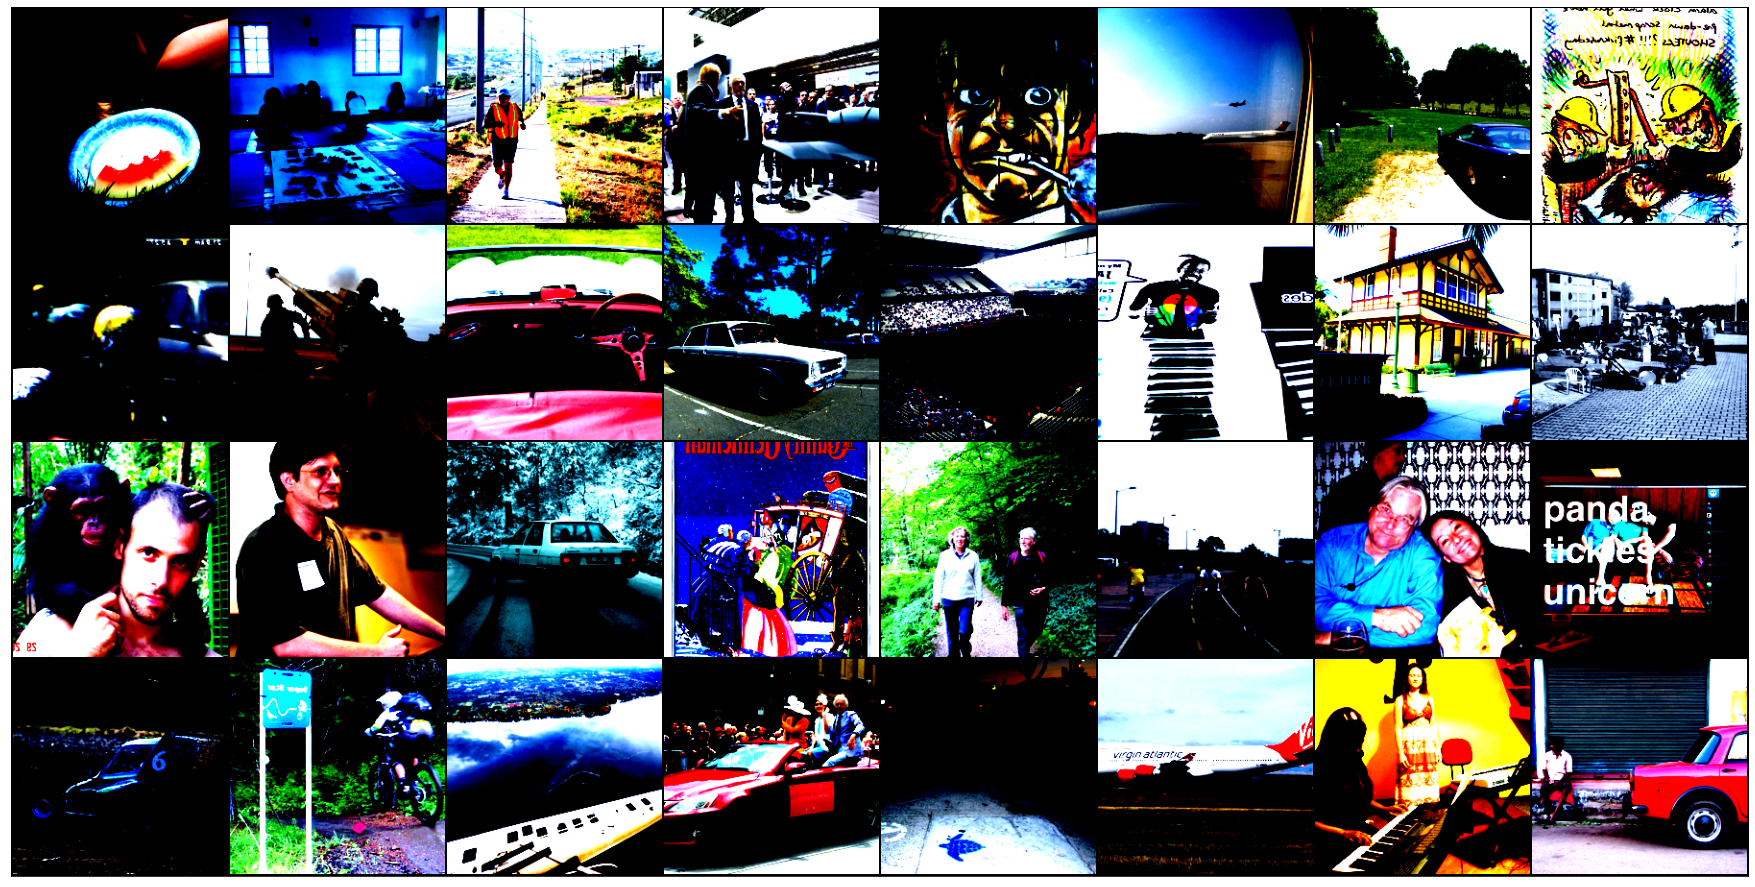

In [88]:
show_batch(trainloader, classes)

## Model

As model we use a ResNet-18 pretrained model. Then we remove last two layers, avg pool layer and classifier layer. We remove avg pool layer because we want to extract the features before pooling, which is very important from the grad-cam algorithm. What happens, with the avg pool we flatten our tensor from 3D to 2D. But we want to create a RGB grad-cam, so we need feature tensor of 3D shape. For that reason we extract features before pooling. By the way, you can attach the hook after any layer, so you can see how much a certain layer is important for the prediction.

**Hook**

Inside the `forward` function, after the feature extraction we attach a hook. We do that to our intermediate values to pull the gradients out of the model before they are discarded. By using hook we register the activation and don't throw them away. But be careful, if we attach the hook during the training process, it will drain all the GPUs memory. So for that reason, we have added a boolean var in the `forward` function. So we can decide when to hook and when not. In our case, we hook the activations only during the Grad-Cam image generation. 

In [9]:
class CustomResnet18(nn.Module):
  def __init__(self, class_num):
    super(CustomResnet18, self).__init__()

    self.class_num = class_num

    backbone = torchvision.models.resnet18(pretrained=True)

    self.fc_inputs = backbone.fc.in_features

    self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2]) # we take layers before the classifier and the avgpool

    self.avgpool = backbone.avgpool

    # classifier
    self.out = nn.Sequential(
        nn.Linear(self.fc_inputs, 256),
        nn.LeakyReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, self.class_num),
    )

    # placeholder for the gradients
    self.gradients = None

  def forward(self, x, reg_hook=True):
      x = self.feature_extractor(x)

      # register hook (needed for grad-cam)
      if reg_hook:
        x.register_hook(self.activations_hook)

      x = self.avgpool(x)

      x = x.view(x.shape[0], -1)  # reshape the tensor
      x = self.out(x)
      return x

  # hook for the gradients of the activations
  def activations_hook(self, grad):
      self.gradients = grad

  def get_activations_gradient(self):
      return self.gradients
  
  def get_activations(self, x):
      return self.feature_extractor(x)

## Training

Here we train the model.

In [21]:
def train(model, criterion, optimizer, file, epochs=9, trainLoss=[], validationLoss=[]):
    print("Starting training")
    best_val_acc=0
    for epoch in range(epochs):
      print('-'*20)
      print(f"Epoch Number: {epoch}")
      print('-'*20)

      testAccuracy = 0
      totalLoss = 0
      for x, y in tqdm(trainloader):
          model.train()
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()

          y_hat = model(x, reg_hook=False)

          l = criterion(y_hat, y)
          totalLoss += l.item()

          l.backward()
          
          optimizer.step()

          y_hat = torch.argmax(y_hat, 1)
        
          testAccuracy += (y_hat == y).sum().item()
      trainLoss.append(totalLoss)
      print(f"Training Accuracy: {testAccuracy / len(training)}")

      ## validation
      valAccuracy = 0
      totalLoss = 0
      with torch.no_grad():
        for x_val, y_val in tqdm(validationloader):
            model.eval()
            x_val, y_val = x_val.to(device), y_val.to(device)

            output = model(x_val, reg_hook=False)

            l = criterion(output, y_val)

            totalLoss += l
            y_hat = torch.argmax(output, 1)
            valAccuracy += (y_hat == y_val).sum().item()

      print(f"Validation Accuracy: {valAccuracy / len(validation)}")
      validationLoss.append(totalLoss)

      if valAccuracy>best_val_acc:
        torch.save(model.state_dict(), file)
        print('Model Saved!')
        
    return trainLoss, validationLoss, model


In [22]:
model = CustomResnet18(len(classes))
model.to(device)
model

CustomResnet18(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0025)

#Specify output file name
file = "ResnetFinal.pth"

output = train(model, criterion, optimizer, file, epochs=32)

Starting training
--------------------
Epoch Number: 0
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.45725


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.5180299032541776
--------------------
Epoch Number: 1
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Training Accuracy: 0.51825


100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Validation Accuracy: 0.5813544415127528
--------------------
Epoch Number: 2
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.55175


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.6112576956904133
--------------------
Epoch Number: 3
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.587


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.6051011433597185
--------------------
Epoch Number: 4
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.60025


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.6015831134564644
--------------------
Epoch Number: 5
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.622


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.4810905892700088
--------------------
Epoch Number: 6
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.63675


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.693051890941073
--------------------
Epoch Number: 7
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.64325


100%|██████████| 36/36 [00:23<00:00,  1.50it/s]


Validation Accuracy: 0.5021987686895338
--------------------
Epoch Number: 8
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Training Accuracy: 0.67575


100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Validation Accuracy: 0.6587510993843447
--------------------
Epoch Number: 9
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.69125


100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Validation Accuracy: 0.6086191732629728
--------------------
Epoch Number: 10
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.691


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7150395778364116
--------------------
Epoch Number: 11
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Training Accuracy: 0.7085


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7264731750219877
--------------------
Epoch Number: 12
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.716


100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Validation Accuracy: 0.6798592788038699
--------------------
Epoch Number: 13
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.71725


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7264731750219877
--------------------
Epoch Number: 14
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.74825


100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


Validation Accuracy: 0.7361477572559367
--------------------
Epoch Number: 15
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.76125


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7379067722075637
--------------------
Epoch Number: 16
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.76275


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7044854881266491
--------------------
Epoch Number: 17
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.78375


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7000879507475813
--------------------
Epoch Number: 18
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Training Accuracy: 0.8005


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.6983289357959542
--------------------
Epoch Number: 19
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.81375


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


Validation Accuracy: 0.7431838170624451
--------------------
Epoch Number: 20
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Training Accuracy: 0.834


100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


Validation Accuracy: 0.712401055408971
--------------------
Epoch Number: 21
--------------------


100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Training Accuracy: 0.84125


100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


Validation Accuracy: 0.7475813544415127
--------------------
Epoch Number: 22
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.85925


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7264731750219877
--------------------
Epoch Number: 23
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.40it/s]


Training Accuracy: 0.88525


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.702726473175022
--------------------
Epoch Number: 24
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.88275


100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


Validation Accuracy: 0.7686895338610378
--------------------
Epoch Number: 25
--------------------


100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Training Accuracy: 0.8945


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7000879507475813
--------------------
Epoch Number: 26
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.9015


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7387862796833773
--------------------
Epoch Number: 27
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.916


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7185576077396658
--------------------
Epoch Number: 28
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.9335


100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Validation Accuracy: 0.7264731750219877
--------------------
Epoch Number: 29
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Training Accuracy: 0.9245


100%|██████████| 36/36 [00:23<00:00,  1.56it/s]


Validation Accuracy: 0.7053649956024626
--------------------
Epoch Number: 30
--------------------


100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Training Accuracy: 0.935


100%|██████████| 36/36 [00:23<00:00,  1.55it/s]


Validation Accuracy: 0.7308707124010554
--------------------
Epoch Number: 31
--------------------


100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Training Accuracy: 0.94275


100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

Validation Accuracy: 0.6781002638522428


The model get a good validation accuracy

In [41]:
# load weights
import random
trained_model = CustomResnet18(len(classes))
trained_model.to(device)

#You can choose to load the weights I obtained previously through training, or you can choose to load the weights obtained through training above (ResnetFinal.pth)

def loadWeights(model, path):
  #Check if GPU is available
  if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
  else:
    map_location='cpu'

  #Load the weights for the model
  model.load_state_dict(torch.load(path, map_location=map_location))

loadWeights(trained_model, "ResnetFinal.pth")

## Drawing Grad-CAM

First, let’s make the forward pass through the network with the imput image and see what the VGG19 predicts. Don’t forget to set your model into the evaluation mode, otherwise you can get very random results. The we do the back-propagation with the logit of the predicted class.

Then we pool the gradient from the layer where we attached a hook. Finally, we obtain the heat-map for the predicted. It is a 14x14 single channel image. The size is dictated by the spacial dimensions of the activation maps in the last convolutional layer of the network.

For a nice result, we use OpenCV to interpolate the heat-map and project it onto the original image.

In [89]:
# Dataloader for grad cam
# the data set could be the validation set ot test set
# remember to set batch_size = 1
grad_validationloader = DataLoader(dataset = validation, batch_size = 1, shuffle = True)

In [90]:
def superimpose_heatmap(heatmap, img):
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.005 + img[0].cpu().permute(1,2,0)
    
    return superimposed_img
    
def get_grad_cam(net, img):
    net.eval()
    img = img.cuda()
    pred = net(img, True)

    # get the gradient of the output with respect to the parameters of the model
    pred[:,pred.argmax(dim=1)].backward()
    
    # pull the gradients out of the model
    gradients = net.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = net.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    
    #print(heatmap)
    # draw the heatmap
    #plt.matshow(heatmap.squeeze())

    return torch.Tensor(superimpose_heatmap(heatmap, img).permute(2,0,1))

In [91]:
n_imgs = 10
img_w = 224
img_h = 224

imgs = torch.Tensor(3, n_imgs, 3, img_h, img_w) #(layers (main img and grad img), num of images, color channels, img h, img h)
true_labels = []
it = iter(grad_validationloader)

for i in range(0, n_imgs):
    img, label = next(it)
    imgs[0][i] = img[0]
    imgs[1][i] = get_grad_cam(trained_model, img)
    true_labels.append(label.item())

torchvision.utils.save_image(imgs.view(-1, 3, img_h, img_w), "gradcam_at_layer.png", nrow=n_imgs, pad_value=1) #to save grad-cam

Show Grad Cam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

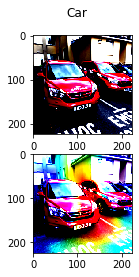

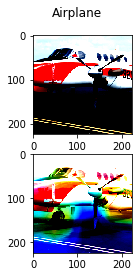

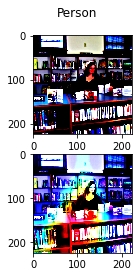

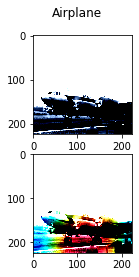

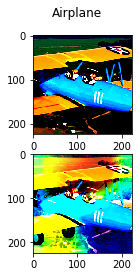

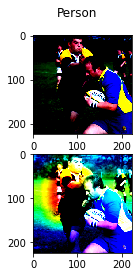

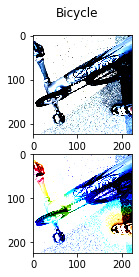

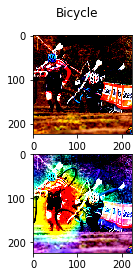

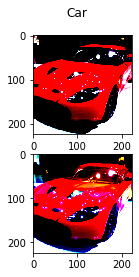

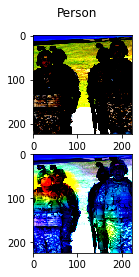

In [93]:
from matplotlib import axes

for i in range(0, n_imgs):
  fig, (ax1, ax2) = plt.subplots(2)
  fig.suptitle(classes[true_labels[i]])
  ax1.imshow(imgs[0][i].permute(1,2,0), interpolation='nearest')
  ax2.imshow(imgs[1][i].permute(1,2,0), interpolation='nearest')